In [44]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
import matplotlib.animation as animation

logger = logging.getLogger(__name__)

In [45]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant

# # the following parameters are not being used in the sample code
PLATFORM_WIDTH = 0.25  # landing platform width
PLATFORM_HEIGHT = 0.  # landing platform height
w1 = [-PLATFORM_WIDTH, PLATFORM_WIDTH]
w2 = [0.1*-PLATFORM_WIDTH, 0.1*PLATFORM_WIDTH]
h = [PLATFORM_HEIGHT, PLATFORM_HEIGHT]
ROTATION_ACCEL = np.radians(20)  # rotation constant

In [46]:
# define system dynamics
# Notes:
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        """

        delta_state_ori = ROTATION_ACCEL* FRAME_TIME*t.tensor([0., 1, 0., 0., 0., 0.])

        sin = t.matmul(t.tensor([[0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [-1., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.]]),t.sin(t.transpose(state,0,1)))
        cos = t.matmul(t.tensor([[0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [1., 0., 0., 0., 0., 0.]]),t.cos(t.transpose(state,0,1)))
        cos_sin = cos+sin
        cos_sin = t.transpose(cos_sin,0,1)
        delta_state_pos = BOOST_ACCEL* FRAME_TIME*t.tensor([0., 0., 0., 1., 0., 1.])*cos_sin # x and y components of acceleration

        delta_state_combine = delta_state_ori + delta_state_pos

        action_mat = t.tensor([[0., 0.],
                         [2., 0.],
                         [0., 0.],
                         [0., 1.],
                         [0., 0.],
                         [0., 1.]])

        a_a = t.add(t.transpose(t.matmul(action_mat, t.transpose(action,0,1)),0,1) , t.tensor([0., -1., 0., 0., 0., 0.]))# get ori and pos accelerations

        delta_state = delta_state_combine*a_a

        state_gravity = GRAVITY_ACCEL * FRAME_TIME*t.tensor([0., 0., 0., 0., 0., -1.])
        state = state + delta_state + state_gravity

        step_mat = t.tensor([[1., FRAME_TIME, 0., 0., 0., 0.],
                             [0., 1., 0., 0., 0., 0.],
                             [0., 0., 1., FRAME_TIME, 0., 0.],
                             [0., 0., 0., 1., 0., 0.],
                             [0., 0., 0., 0., 1., FRAME_TIME,],
                             [0., 0., 0., 0., 0., 1.]])
        state = t.transpose(t.matmul(step_mat, t.transpose(state,0,1)),0,1)

        return state

In [47]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden1, dim_hidden2, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden1),
            nn.Tanh(),
            nn.Linear(dim_hidden1, dim_hidden2),
            nn.Tanh(),
            nn.Linear(dim_hidden2, dim_output),
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [48]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T, N):
        super(Simulation, self).__init__()
        self.state = self.initialize_state(N)
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state(n):
        initial = np.zeros((n,6))
        for i in range(n):
            initial[i] = [0.5*math.pi*(random.random()-0.5), 0.1*math.pi*(random.random()-0.5), # orientation state
                     (random.random()-0.5), 0.1*(random.random()-0.5), # horizontal state
                     0.5*random.random()+1, -0.1*random.random()]  # vertical state
        print(initial)
        return t.tensor(initial, requires_grad=False).float()
    def error(self, state):
        states = t.square(state).sum(dim=0)*t.tensor([1., 1., 0.01, 1., 1., 1.0]) # weight of each state
        return states.sum(dim=0)

In [49]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()

    def train(self, eps, max_epoch):
        conv_log = []
        conv_itr = []
        epoch = 0
        error = 100
        while error > eps and epoch <= max_epoch:
            loss = self.step()
            conv_log.append(loss.item())
            conv_itr.append(epoch)
            epoch += 1
            print('[%d] loss: %.3f' % (epoch, loss))
            error = loss.item()
            cord = self.visualize()
        print('Landing Trajectory:')
        for r in range(N):
            plt.quiver(cord[:,r, 2], cord[:,r, 4], -0.05*np.sin(cord[:,r, 0]), 0.05*np.cos(cord[:,r, 0]))
            plt.quiver(cord[-1,r, 2], cord[-1,r, 4], -0.05*np.sin(cord[-1,r, 0]), 0.05*np.cos(cord[-1,r, 0]),color='orange')
            plt.plot(w1, h, color="red", linewidth=3)
            plt.plot(w2, h, color="green", linewidth=3)
            plt.show()
        print('Convergence Plot:')
        plt.plot(conv_itr, conv_log)
        plt.yscale("log")
        plt.show()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        plt.scatter(data[:,0,2], data[:,0,4],s=5)
        plt.plot(w1, h, color="red", linewidth=3)
        plt.plot(w2, h, color="green", linewidth=3)
        plt.show()
        return data

[[-4.06568473e-01  1.54187718e-01  3.84304811e-01  1.58724454e-02
   1.20172964e+00 -6.58913096e-02]
 [ 3.26971318e-01 -1.29192422e-01  1.64416046e-01  4.45516167e-02
   1.27205134e+00 -6.20294268e-02]
 [ 1.73915198e-01  1.36709055e-01 -1.21660742e-01 -3.07696226e-02
   1.34593335e+00 -8.71673572e-02]
 [ 5.02853755e-01 -5.97559381e-02 -3.18519654e-01  1.85627697e-02
   1.32287036e+00 -7.68351376e-02]
 [-2.50209460e-01 -1.20492559e-01  4.65573844e-02 -3.80651747e-03
   1.14479781e+00 -3.03315666e-02]
 [-4.90685223e-01 -6.76451938e-02  4.79920117e-01 -1.30604239e-02
   1.02922289e+00 -3.27900017e-02]
 [-6.55185155e-01  1.31394144e-01  4.57136197e-01 -2.75655723e-02
   1.07438828e+00 -5.20875659e-02]
 [ 5.88884655e-01  1.34097855e-01 -7.01595791e-02 -2.50173944e-02
   1.01275436e+00 -4.07672800e-02]
 [ 6.35023661e-01 -1.23488143e-01 -1.10990564e-01  1.86652877e-02
   1.40403367e+00 -1.76688054e-02]
 [-2.20360752e-02  5.36810156e-02 -2.26708020e-01 -3.60991119e-02
   1.38523480e+00 -3.8411

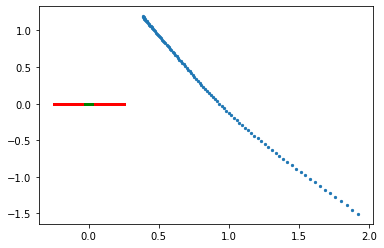

[2] loss: 220.761


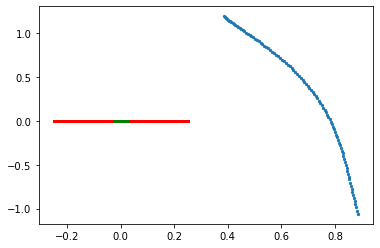

[3] loss: 139.818


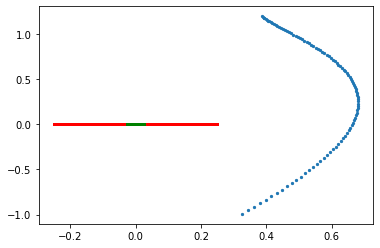

[4] loss: 96.605


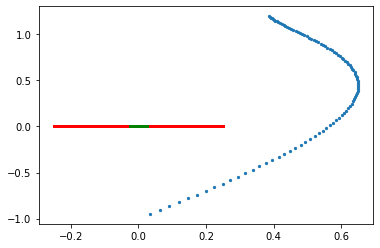

[5] loss: 69.285


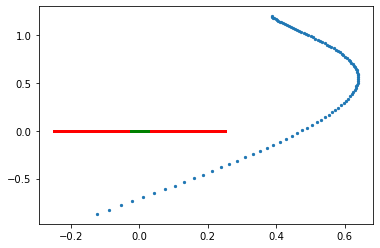

[6] loss: 49.343


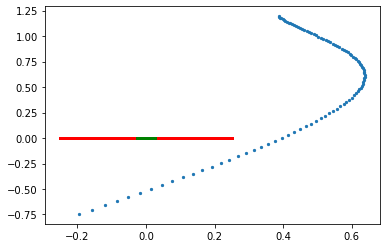

[7] loss: 34.352


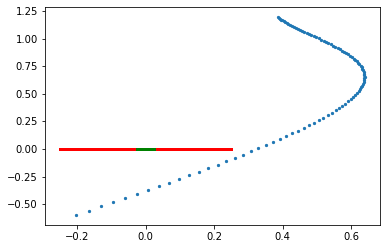

[8] loss: 24.084


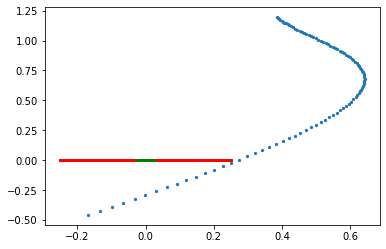

[9] loss: 17.212


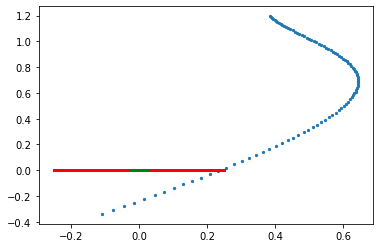

[10] loss: 12.558


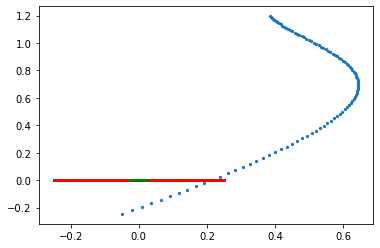

[11] loss: 9.456


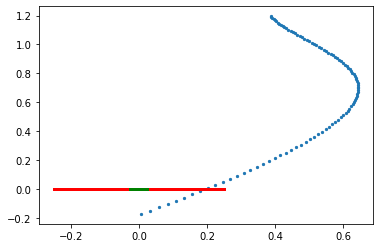

[12] loss: 7.346


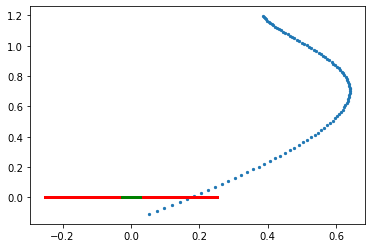

[13] loss: 5.894


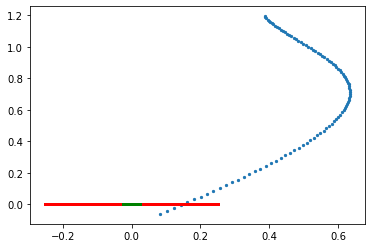

[14] loss: 4.868


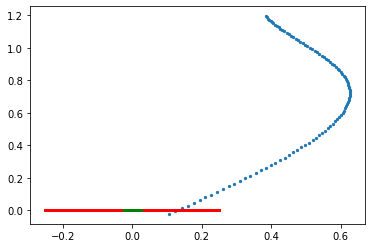

[15] loss: 4.045


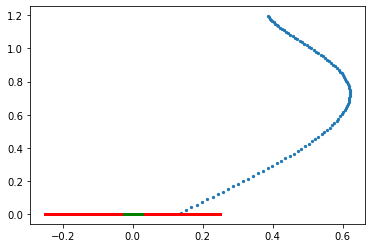

[16] loss: 3.015


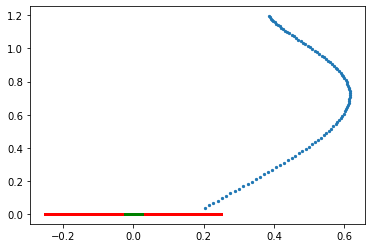

[17] loss: 1.822


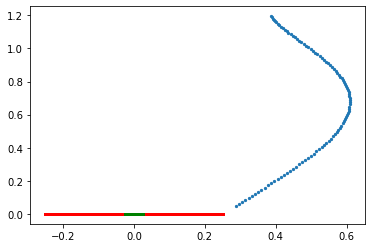

[18] loss: 1.207


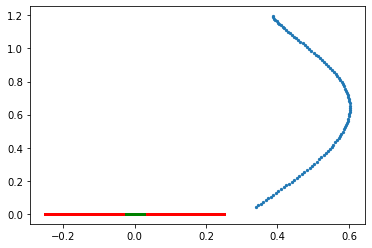

[19] loss: 0.814


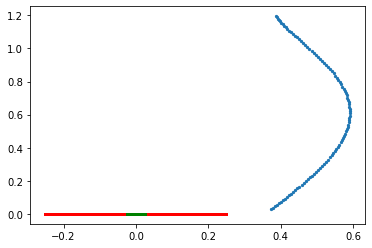

[20] loss: 0.600


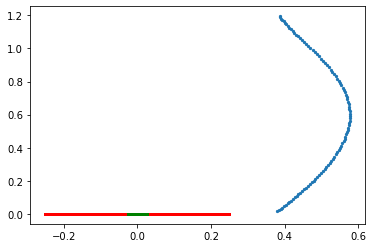

[21] loss: 0.475


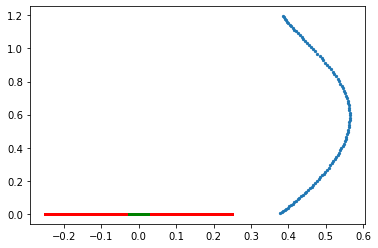

[22] loss: 0.382


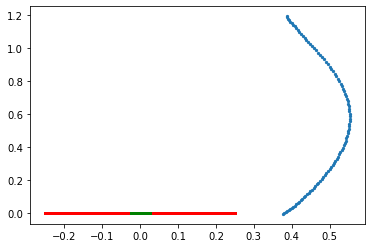

[23] loss: 0.299


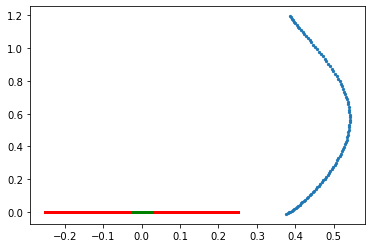

[24] loss: 0.230


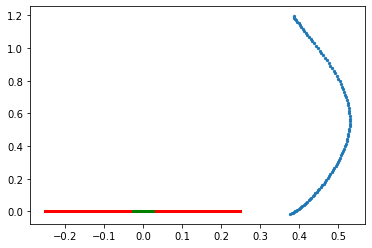

[25] loss: 0.175


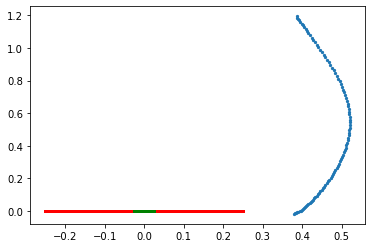

[26] loss: 0.135


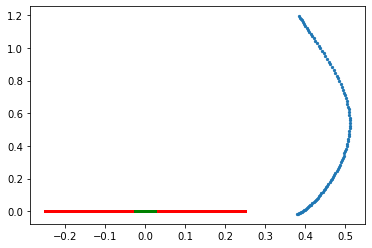

[27] loss: 0.107


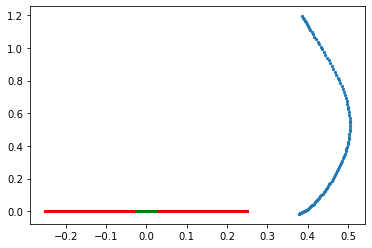

[28] loss: 0.086


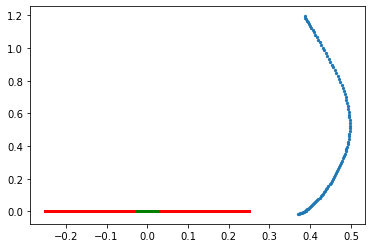

[29] loss: 0.070


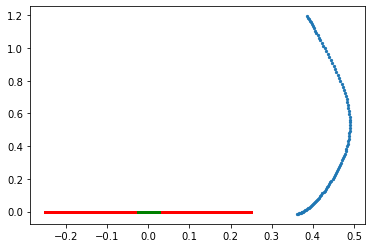

[30] loss: 0.058


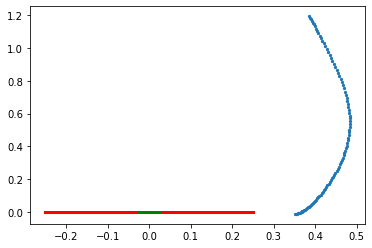

[31] loss: 0.048


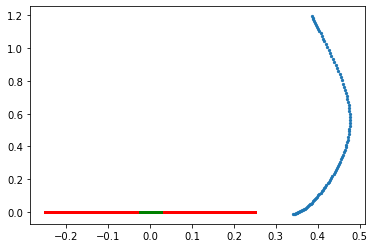

[32] loss: 0.041


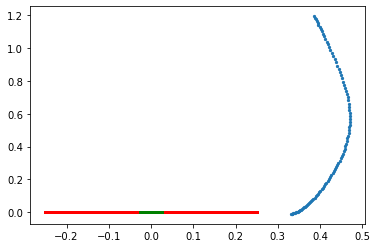

[33] loss: 0.035


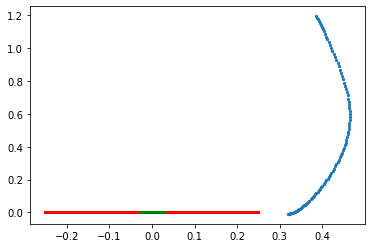

[34] loss: 0.030


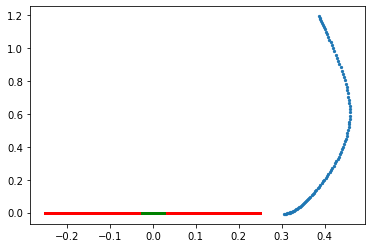

[35] loss: 0.026


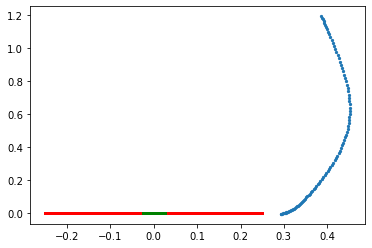

[36] loss: 0.022


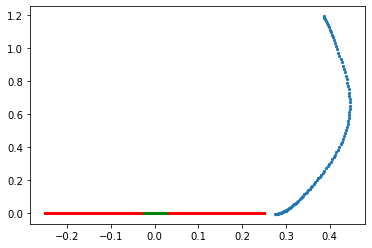

[37] loss: 0.019


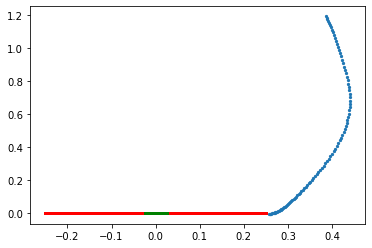

[38] loss: 0.017


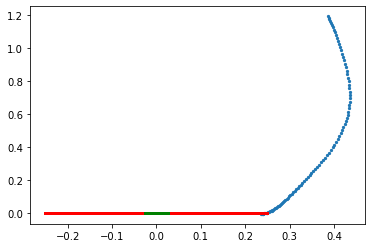

[39] loss: 0.015


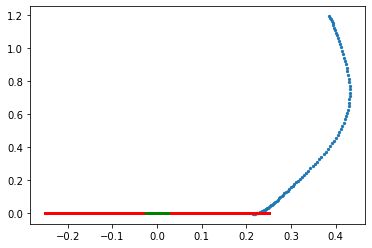

[40] loss: 0.014


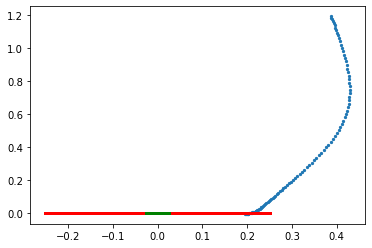

[41] loss: 0.013


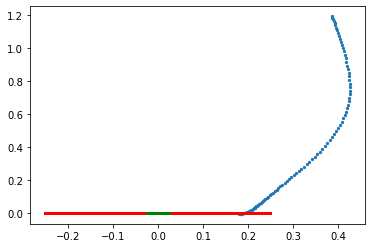

[42] loss: 0.011


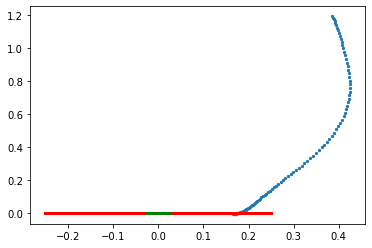

[43] loss: 0.010


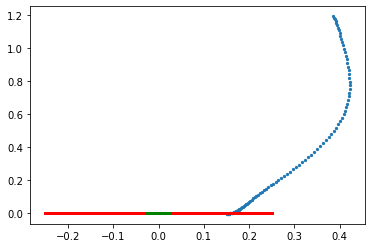

[44] loss: 0.009


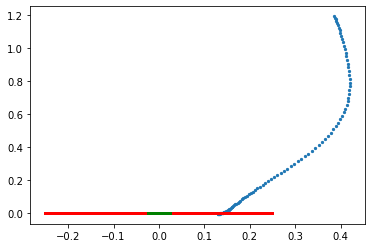

[45] loss: 0.008


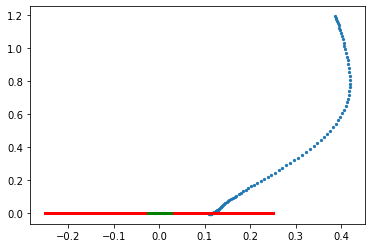

[46] loss: 0.007


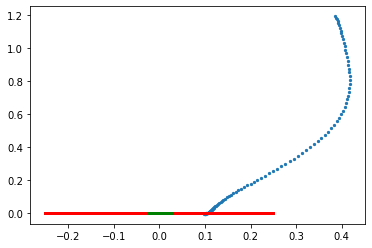

[47] loss: 0.007


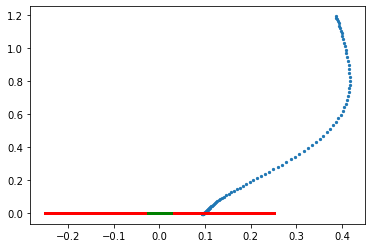

[48] loss: 0.006


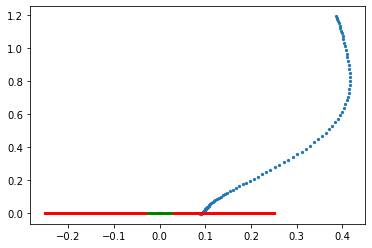

[49] loss: 0.006


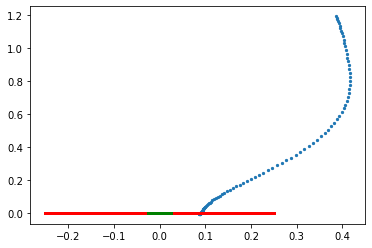

[50] loss: 0.006


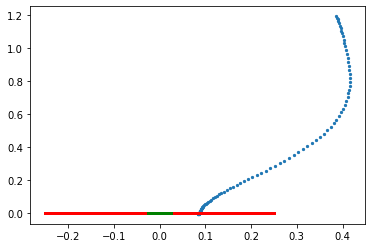

[51] loss: 0.005


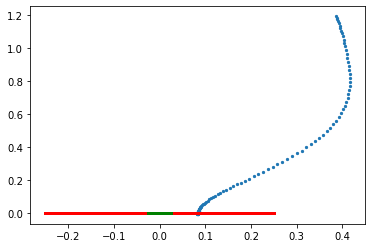

[52] loss: 0.004


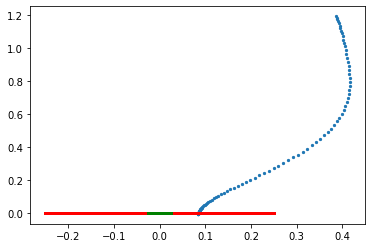

[53] loss: 0.004


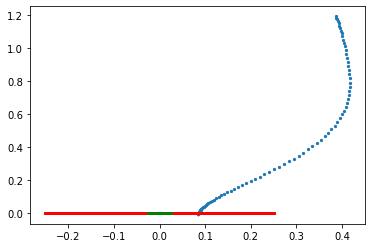

[54] loss: 0.003


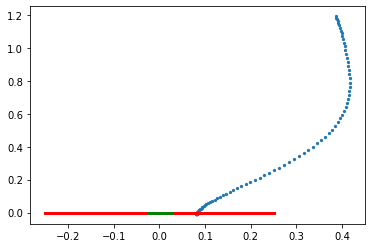

[55] loss: 0.002


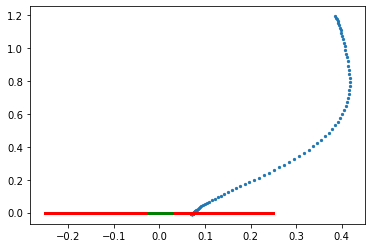

[56] loss: 0.002


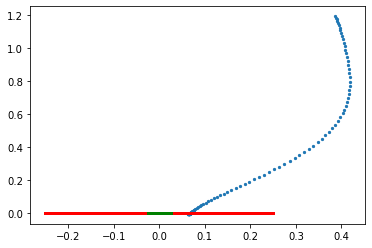

[57] loss: 0.001


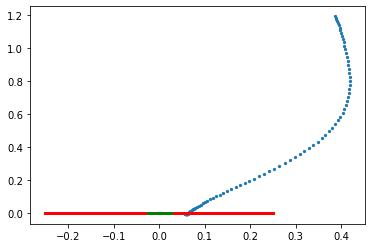

[58] loss: 0.001


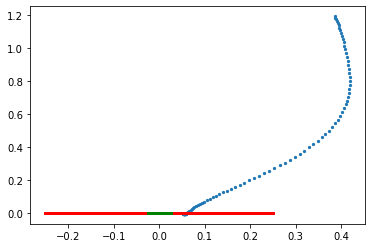

[59] loss: 0.001


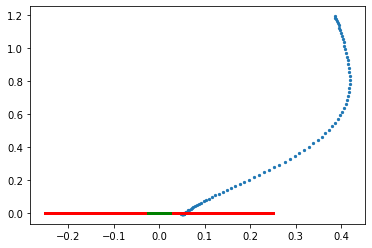

[60] loss: 0.001


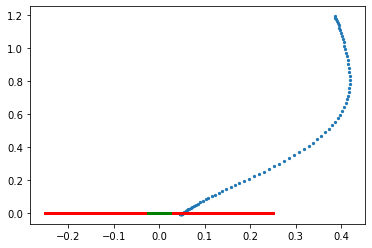

[61] loss: 0.001


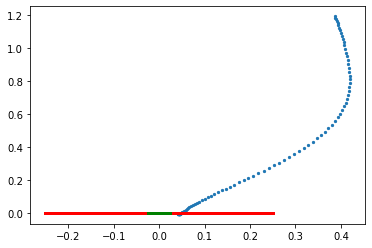

[62] loss: 0.001


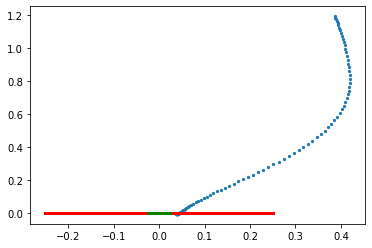

[63] loss: 0.001


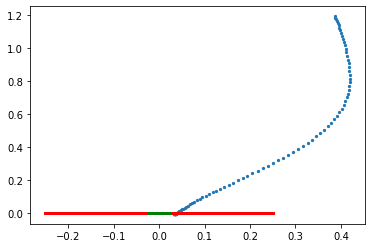

[64] loss: 0.001


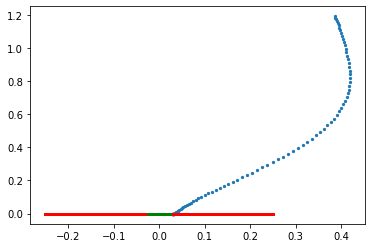

[65] loss: 0.001


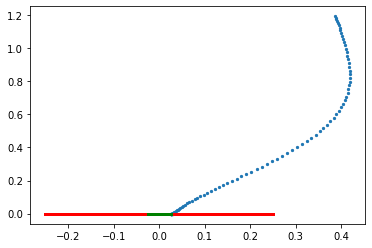

[66] loss: 0.000


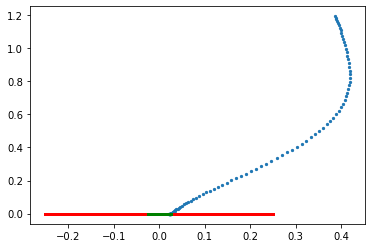

[67] loss: 0.000


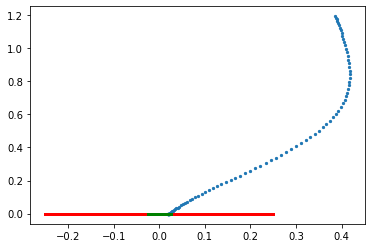

[68] loss: 0.000


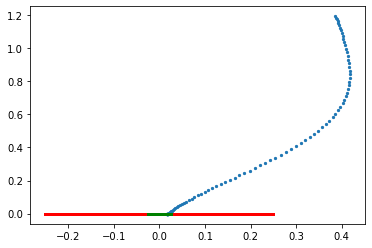

[69] loss: 0.000


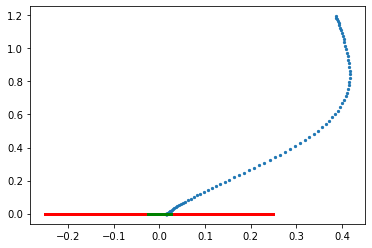

[70] loss: 0.000


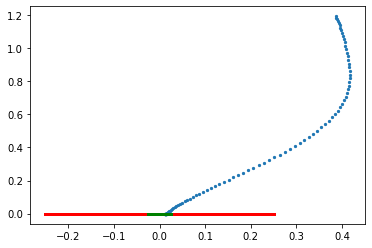

[71] loss: 0.000


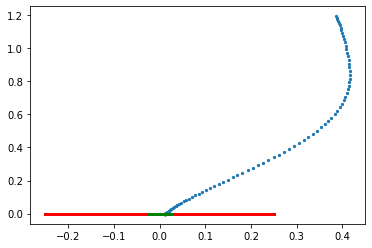

[72] loss: 0.000


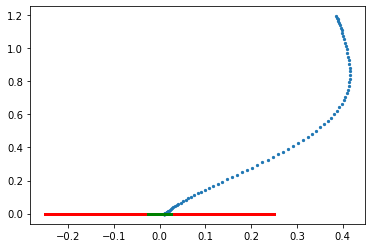

[73] loss: 0.000


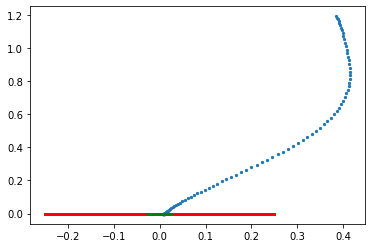

[74] loss: 0.000


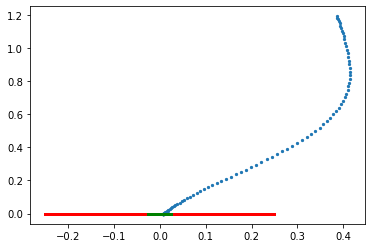

[75] loss: 0.000


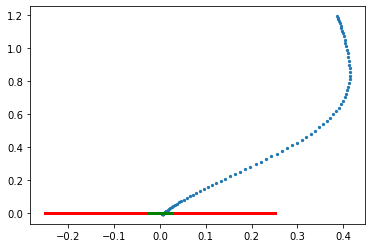

[76] loss: 0.000


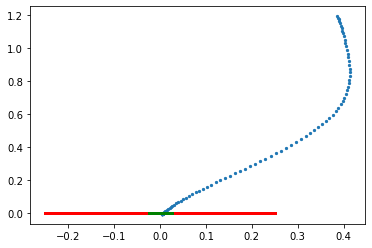

[77] loss: 0.000


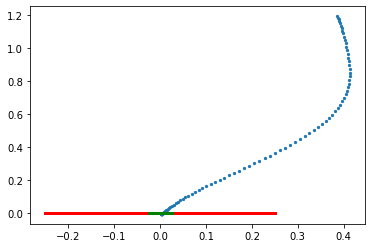

[78] loss: 0.000


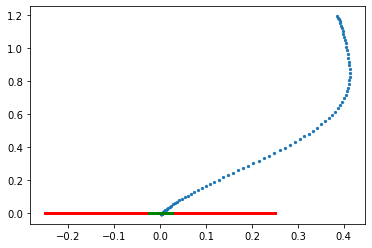

[79] loss: 0.000


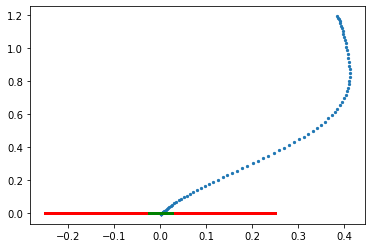

[80] loss: 0.000


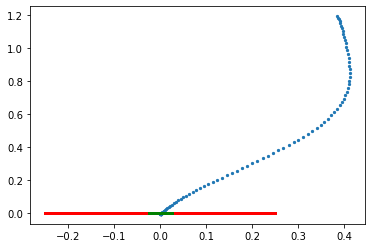

Landing Trajectory:


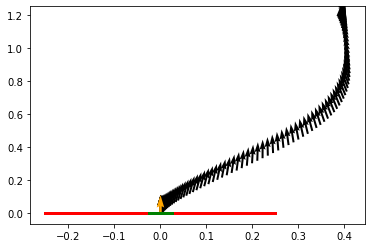

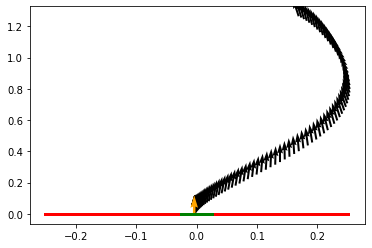

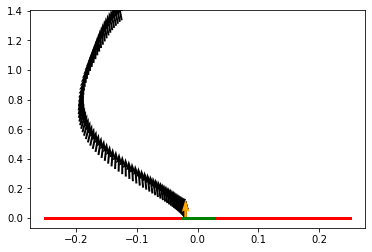

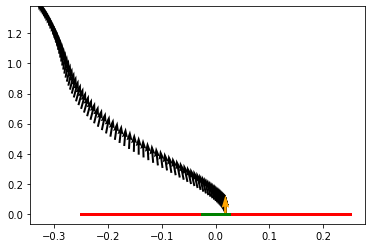

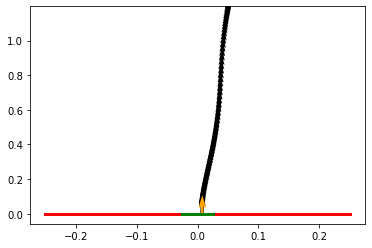

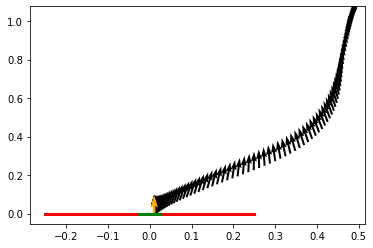

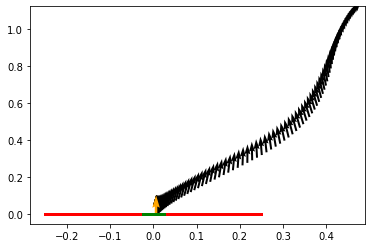

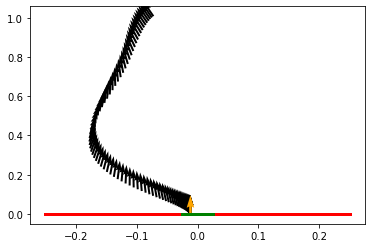

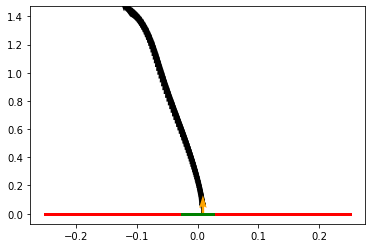

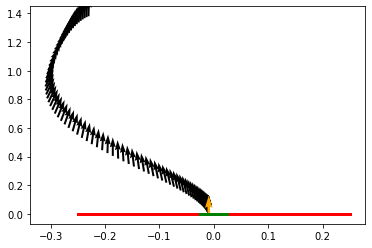

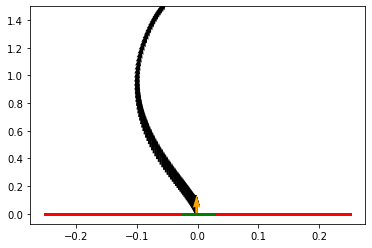

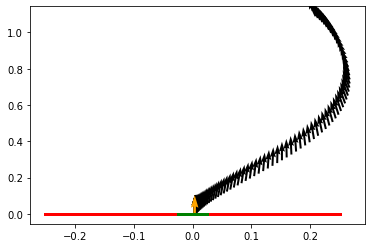

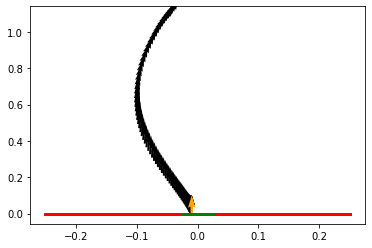

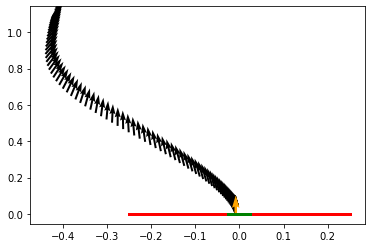

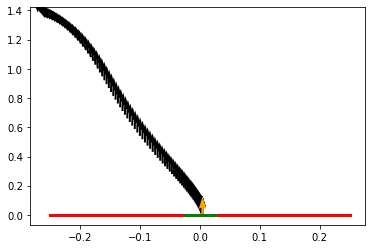

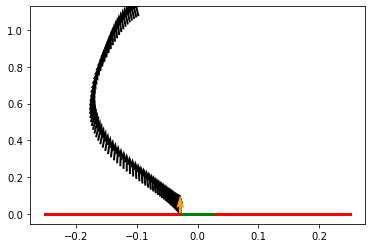

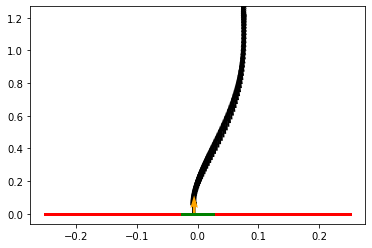

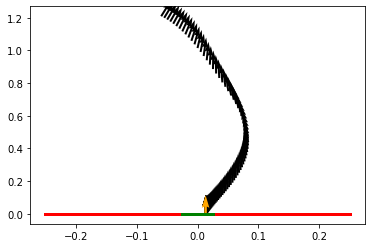

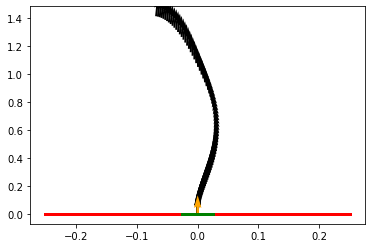

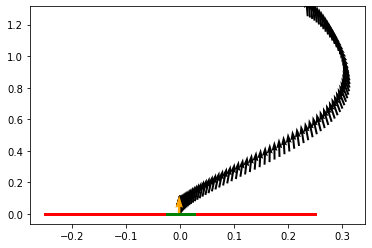

Convergence Plot:


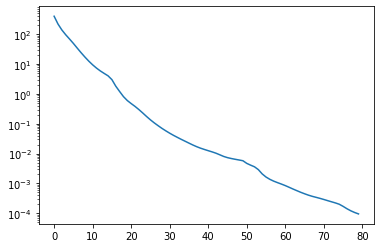

In [50]:
# Now it's time to run the code!

T = 100  # number of time steps
N = 20  # number of initial states
err = 0.0001 # acceptable_error
itr = 120 # max_iteration
dim_input = 6  # state space dimensions
dim_hidden1 = 12  # latent dimensions
dim_hidden2 = 4  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden1, dim_hidden2, dim_output)  # define controller
s = Simulation(c, d, T, N)  # define simulation
o = Optimize(s)  # define optimizer
o.train(err,itr)  # solve the optimization problem

path = './Landing_Model.pth'
t.save(c.state_dict(),path)

In [51]:
print(c.state_dict())

OrderedDict([('network.0.weight', tensor([[-0.6095, -0.5989, -0.5851,  1.9888,  0.5259,  0.2977],
        [ 1.0497,  0.9964, -0.5207, -3.4800,  0.6189, -0.4796],
        [-0.0667,  0.3416, -0.9556, -0.1931,  2.6945,  0.2699],
        [ 1.2315, -0.2758,  2.3127, -2.1310,  2.1485,  0.9462],
        [-0.7247, -0.3443,  0.0433,  1.8761, -0.0989,  2.4304],
        [ 0.1039, -0.2495,  0.3730,  0.7708,  0.0462, -2.1187],
        [-0.7517, -0.2129,  0.8651,  0.3399, -0.1563, -2.1224],
        [ 0.2841, -0.2208,  1.4325, -0.4087,  2.2686,  0.4719],
        [ 0.3830,  0.8488, -0.2673, -2.6608,  0.7451,  1.3627],
        [-0.2703,  0.3031,  0.3828, -0.4112, -0.0740,  1.3147],
        [ 0.5556,  0.2080,  1.0656, -1.1633, -3.0132,  0.3506],
        [ 0.3065,  0.3095, -2.9078, -2.0552, -1.8798, -0.1047]])), ('network.0.bias', tensor([ 0.8820,  0.0234,  0.4853,  0.4387,  0.3045, -0.1657,  0.5771,  0.4832,
         0.5029, -0.6519, -0.3258,  0.9462])), ('network.2.weight', tensor([[ 0.8820, -1.2412, -